In [1]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt
import numpy as np
from numpy import cross, allclose
from numpy.linalg import norm, dot, multi_dot
import math
import random
from scipy.spatial import distance
import transforms3d

from collections import namedtuple

%matplotlib notebook

ImportError: cannot import name 'dot' from 'numpy.linalg' (/usr/lib/python3/dist-packages/numpy/linalg/__init__.py)

In [ ]:
def normalize(v):
    return v/norm(v)

def transform_coordlist_mat(l, mat):
    #print(mat)
    def mf(c):
        in_c = np.array([c[0], c[1], c[2], 1])
        out = np.array(mat).dot(in_c)
        return [out[0], out[1], out[2]]
    return np.array(list(map(mf, l)))


In [514]:
class BaseStationConfig:
    
    def __init__(self, stations):
        self.stations = []
        
class BaseStation:
    
    def __init__(self, translation, rotation):
        self.translation = translation
        self.rotation = rotation
        
    def transform_coord_list(self, points):
        return transform_coordlist_mat(points, self.translation)
    
def gen_outer_xy(full_range, part):
    x = 0
    y = 0
    
    while abs(x) < full_range - part and abs(y) < full_range - part:
        x = random.random() * 2 - 1
        y = random.random() * 2 - 1

    return (x, y)

def gen_rand_basestation():
    
    # Translation
    xpos, ypos = gen_outer_xy(1, 0.2)
    zpos = random.random() / 4 + 0.75
    translation = np.array([
        [1, 0, 0, xpos],
        [0, 1, 0, ypos],
        [0, 0, 1, zpos],
        [0, 0, 0, 1],
    ])
    
    # Rotation
    # Point towards center
    ang_to_center = math.atan2(xpos, ypos)
    rotation = transforms3d.axangles.axangle2mat([0, 0, 1], -ang_to_center-(math.pi/2), True)
    # Random 
    
    return BaseStation(translation=translation, rotation=rotation)

def gen_rand_2_basestations():
    # First basestatinon position
    b1 = gen_rand_basestation()
    
    # Second basestation position. 
    # Ensure at least a certain distance away from first
    #while True:
    #    b2 = gen_rand_basestation()
    #   if distance.euclidean(b1, b2) > 0.6:
    #        break
    
bst = gen_rand_basestation()
print(bst.translation)
print(transform_coordlist_mat([[0, 0, 0]], bst.translation))

gen_rand_2_basestations()

[[ 1.          0.          0.         -0.64241655]
 [ 0.          1.          0.         -0.99872549]
 [ 0.          0.          1.          0.93115562]
 [ 0.          0.          0.          1.        ]]
[[-0.64241655 -0.99872549  0.93115562]]


In [515]:
# BASE STATION VISUALIZATION GRAPHIC
lighthouse_graphic_model = [
    [(0, 0, 0), (1, 0.5, -0.5), (1, 0.5, 0.5),
     (0, 0, 0), (1, -0.5, -0.5), (1, -0.5, 0.5),
     (0, 0, 0)],
    [(1, 0.5, -0.5),(1, -0.5, -0.5)],
    [(1, 0.5, 0.5),(1, -0.5, 0.5)]
]

def lookat(pos, direction):
    if direction[0] == 0 and direction[1] == 0:
        raise "nope"
    direction = normalize(direction)
    
    print(cross(np.array([0, 0, -1]), np.array(direction)))
    print([0, 0, -1], direction)
    right_vec = normalize(cross([0, 0, -1], direction))
    up_vec = normalize(cross(direction, right_vec))
    forward_vec = normalize(cross(right_vec, up_vec))
    print(right_vec)
    print(up_vec)
    
    # Sanity check, check that the direction of our input and our forward vector
    # is the same.
    assert(allclose(forward_vec, direction))
    
    tr_mat = [
        [forward_vec[0], right_vec[0], up_vec[0]],
        [forward_vec[1], right_vec[1], up_vec[1]],
        [forward_vec[2], right_vec[2], up_vec[2]],
    ]
    return tr_mat

def lookat(pos, dest, up_init):
    pos = np.array(pos)
    dest = np.array(dest)
    up_init = np.array(up_init)
    
    forward = normalize(dest-pos)
    right = cross(up_init, forward)
    up = cross(forward, right)
    
    mat = [
        [forward[0], -right[0], -up[0], pos[0]],
        [forward[1], -right[1], -up[1], pos[1]],
        [forward[2], -right[2], -up[2], pos[2]],
        [0, 0, 0, 1],
    ]
    return mat

def mat4vec3(vec, mat):
    return multi_dot([[vec[0], vec[1], vec[2], 0], mat])[0:3]

def gen_lighthouse_graphic(mat):
    return list(map(lambda d: list(map(lambda i: mat4vec3(i, mat), d)), lighthouse_graphic_model))

mat = lookat([0, 0, 0], [1, 1, 1], [0, 0, 1])
print(mat)
o = gen_lighthouse_graphic(mat)

[[0.5773502691896258, 0.5773502691896258, 0.3333333333333334, 0], [0.5773502691896258, -0.5773502691896258, 0.3333333333333334, 0], [0.5773502691896258, -0.0, -0.6666666666666669, 0], [0, 0, 0, 1]]


<IPython.core.display.Javascript object>


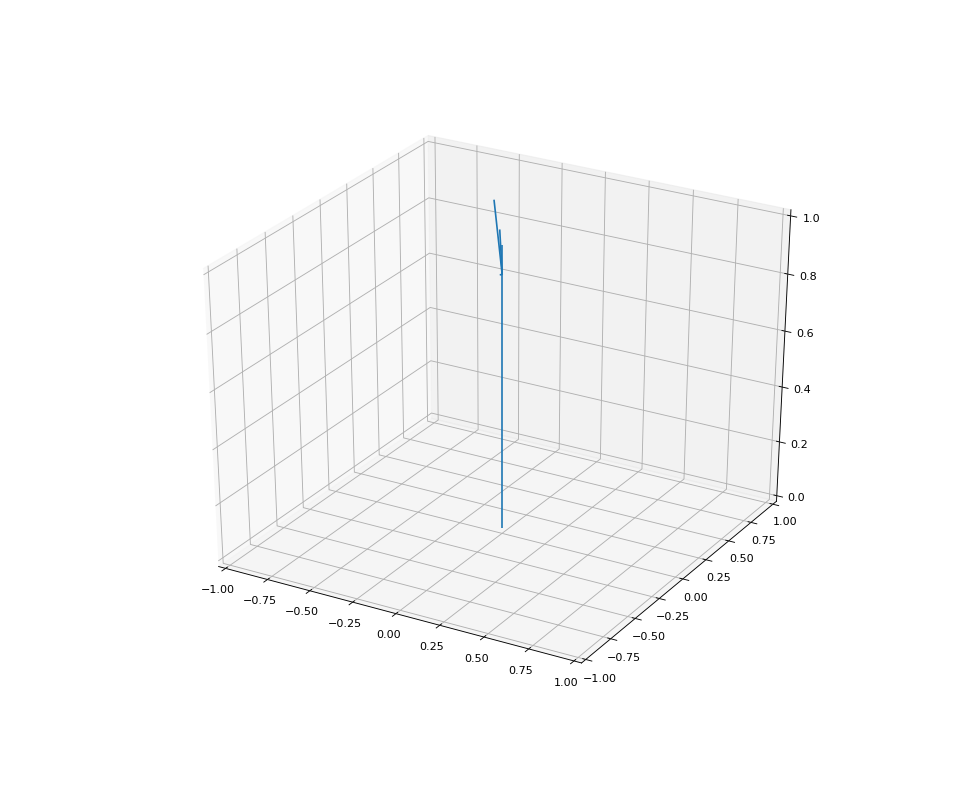

[ 0.53556162 -0.84449615  0.        ]
[[ 1.          0.          0.         -0.52684331]
 [ 0.          1.          0.          0.83074876]
 [ 0.          0.          1.          0.90377399]
 [ 0.          0.          0.          1.        ]]


In [523]:
fig = plt.figure(figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(0, 1)

#ax.add_collection3d(Line3DCollection(o, linewidths=1), zs='z')
ax.add_collection3d(Line3DCollection([[[0, 0, 0], [0, 0, 1]]]))

#print(bst.translation)
#print(bst.rotation)

def draw_base_station(ax, bst):
    bst1_arrow_coords = bst.transform_coord_list([[0, 0, 0], [1, 0, 0]])
    bst1_arrow_dir = bst.rotation.dot([1, 0, 0])
    print(bst1_arrow_dir)
    ax.quiver(
        bst1_arrow_coords[0][0], bst1_arrow_coords[0][1], bst1_arrow_coords[0][2],
        bst1_arrow_dir[0], bst1_arrow_dir[1], bst1_arrow_dir[2]
    )
    
bst = gen_rand_basestation()
draw_base_station(ax, bst)

print(bst.translation)

#bst1_arrow_coords = bst.transform_coord_list([[0, 0, 0], [1, 0, 0]])
#ax.quiver(0.5, 0.5, 0.5, 1, 0.5, 0.5)


plt.show()